# 1. Loads libraries

In [ ]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)



#2. Loads Images

In [ ]:
#Setting some inital parameters
height, width = 224, 224
batch_size=64

In [ ]:
data_dir = 'brain-mri-images-for-brain-tumor-detection/'

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


#3. Image demonstration

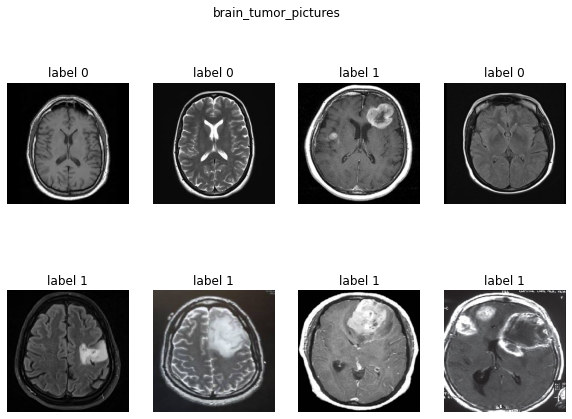

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

# 4. CNN Implementation



#4.1 VGG19 Implementation
The architecture of VGG19:
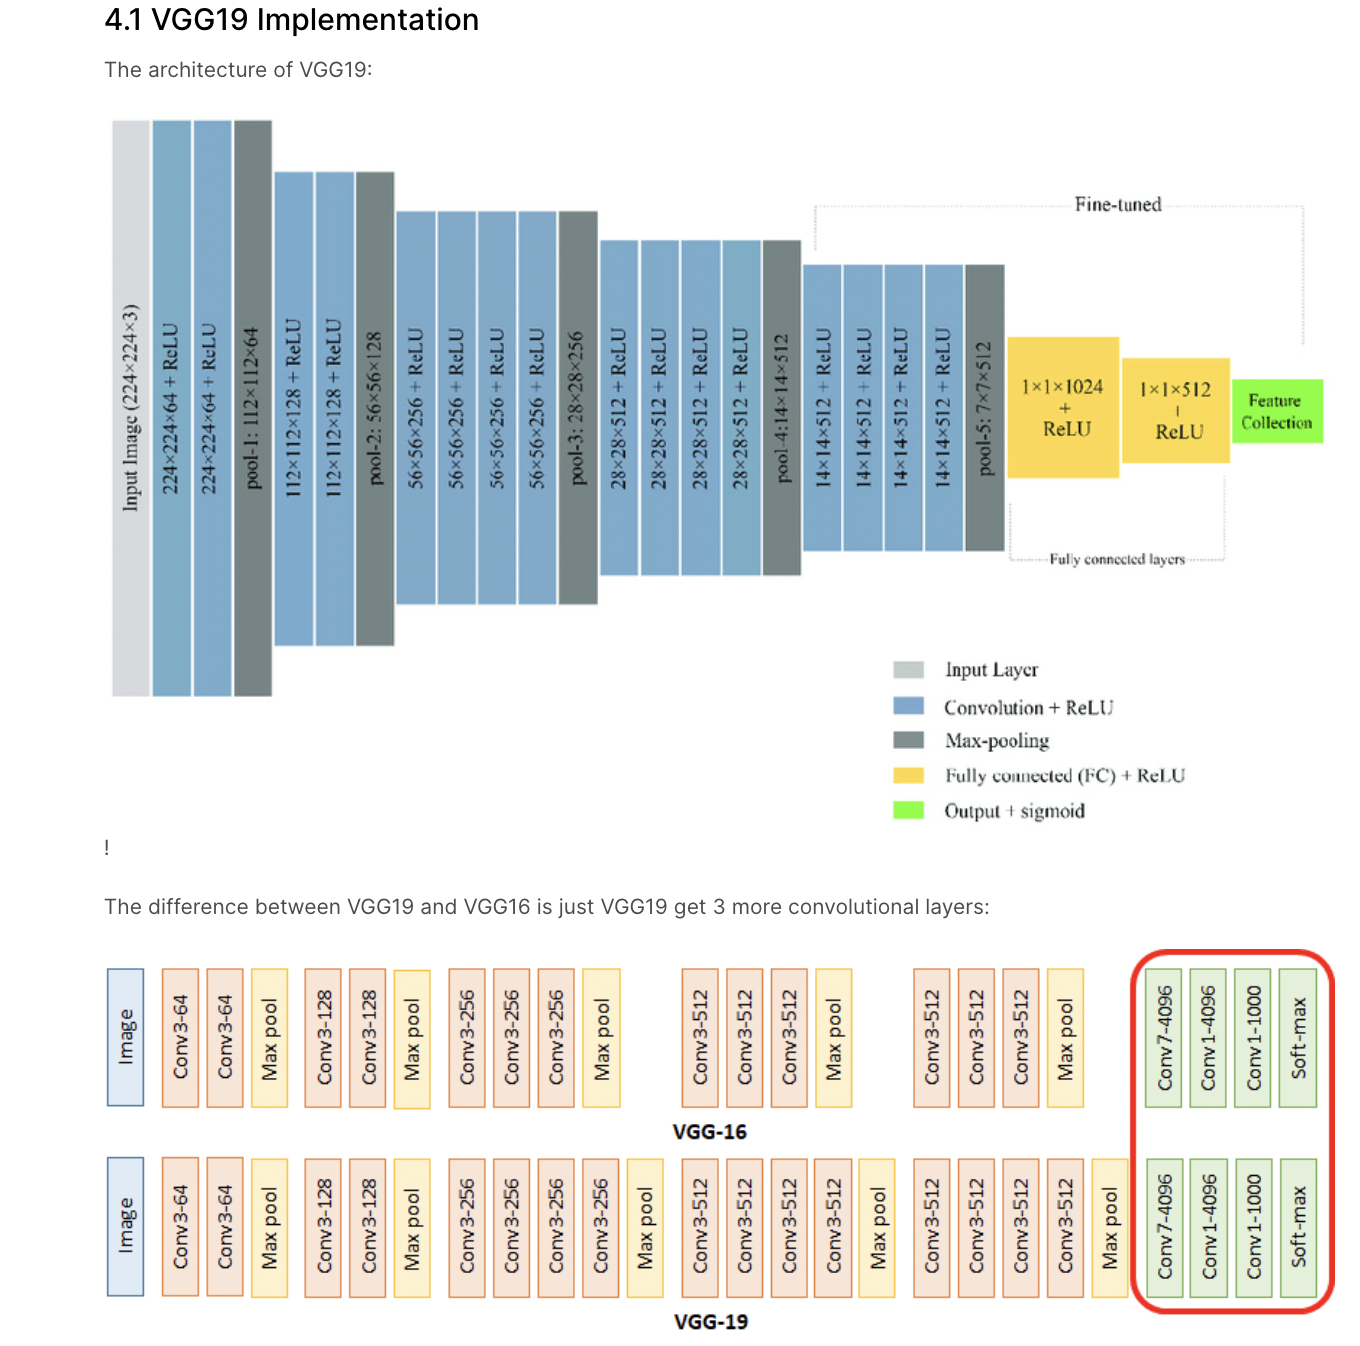

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)


Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 10.5927 - acc: 0.5172 
Epoch 1: acc improved from -inf to 0.51724, saving model to model/vgg19_best.h5
4/4 [==============================] - 171s 41s/step - loss: 10.5927 - acc: 0.5172 - val_loss: 12.9454 - val_acc: 0.6200
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 10.4471 - acc: 0.6108 
Epoch 2: acc improved from 0.51724 to 0.61084, saving model to model/vgg19_best.h5
4/4 [==============================] - 167s 53s/step - loss: 10.4471 - acc: 0.6108 - val_loss: 2.8704 - val_acc: 0.7800
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 5.0825 - acc: 0.5616 
Epoch 3: acc did not improve from 0.61084
4/4 [==============================] - 165s 52s/step - loss: 5.0825 - acc: 0.5616 - val_loss: 4.2078 - val_acc: 0.7200
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 3.2243 - acc: 0.7537 
Epoch 4: acc improved from 0.61084 to 0.75369, saving model to model/vgg19_best.h

In [ ]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

1/1 [==============================] - 33s 33s/step - loss: 0.6044 - acc: 0.8800


,Train,Val
Loss,0.000909,0.604441
Acc,1.000000,0.880000


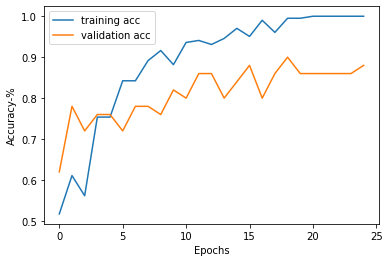

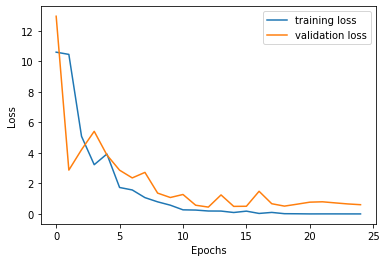

In [ ]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [ ]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 253 images belonging to 2 classes.


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 0.5011 - acc: 0.8775 
Epoch 1: acc did not improve from 1.00000
4/4 [==============================] - 216s 53s/step - loss: 0.5011 - acc: 0.8775 - val_loss: 0.4209 - val_acc: 0.8600 - lr: 0.0100
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.4393 - acc: 0.8340 
Epoch 2: acc did not improve from 1.00000
4/4 [==============================] - 205s 54s/step - loss: 0.4393 - acc: 0.8340 - val_loss: 0.3108 - val_acc: 0.9200 - lr: 0.0100
Epoch 3/25
4/4 [==============================] - ETA: 0s - loss: 0.3737 - acc: 0.8656 
Epoch 3: acc did not improve from 1.00000
4/4 [==============================] - 199s 52s/step - loss: 0.3737 - acc: 0.8656 - val_loss: 0.1888 - val_acc: 0.9000 - lr: 0.0100
Epoch 4/25
4/4 [==============================] - ETA: 0s - loss: 0.3245 - acc: 0.8577 
Epoch 4: acc did not improve from 1.00000
4/4 [==============================] - 198s 52s/step - loss: 0.3245 - acc: 0.8577 - 

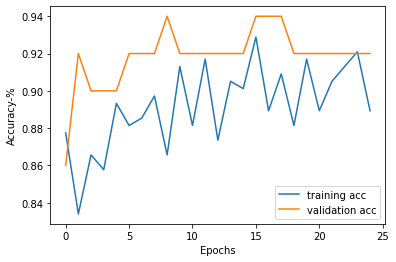

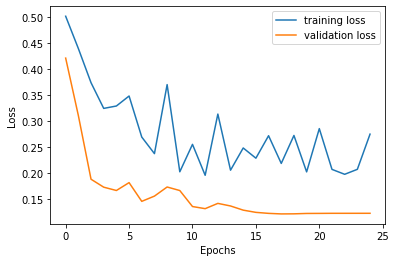

In [ ]:
plot_learning_curve(history)

In [ ]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df


1/1 [==============================] - 33s 33s/step - loss: 0.1235 - acc: 0.9200


,Train,Val
Loss,0.002868,0.123484
Acc,1.000000,0.920000


In [ ]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

cm=confusion_matrix(y_val, ypred_val)

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

# Final accuracy of our model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

2/2 [==============================] - 32s 12s/step
[[16  3]
 [ 1 30]]

               precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.97      0.91      0.94        33

    accuracy                           0.92        50
   macro avg       0.90      0.93      0.91        50
weighted avg       0.93      0.92      0.92        50

Accuracy: 0.9200
